# Coarser Product Derivation Demonstration

_A guide to setting up a synthetic imagery product degrader and running it_

In [1]:
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)

from src import ProductDataset, Degrader
from src.modules import conv_aggregation, kernels

> For the purpose of this demonstration, you should have already generated a latent product in numpy format under `sandbox` directory following `demo-latent-generation.ipynb`

### Load Latent Product Dataset

In [2]:
latent = ProductDataset(root='sandbox/latent_product_npy')

In [3]:
latent.index['features']

{'width': 2048,
 'height': 2048,
 'nbands': 3,
 'horizon': 32,
 'nblob': 42,
 'nframes': 32}

### Setup Derivation procedure

Derivation procedure must be provided with :

- New spatial resolution or Target image size
- New temporal resolution
- A time-agnostic geometric transform to apply to all images
- An aggregation operator used for downsampling (e.g. `np.mean`, `np.max`)

__Spatial and Temporal resolutions__

In [4]:
# Target size
target_size = (512, 512)

# Temporal Resolution
temporal_res = 1

__Geometric Transformation__

To account for varying incidence angle between satellites, we propose to add some perspective to the image. The lower the spatial resolution the greater this perspective distortion should be - this can be tuned through the `scale` parameter in the following.
As all images are saved in numpy array format, we favor `imgaug` augmenters for this operation.

In [5]:
# Geometric transform
transform = iaa.PerspectiveTransform(scale=(0.08, 0.12),   # Randomly drawn between these 2 values
                                     keep_size=True,      # Ensure image size isn't altered
                                     fit_output=True)     # Ensure image isn't cropped

> _Perspective visualization on dummy example_

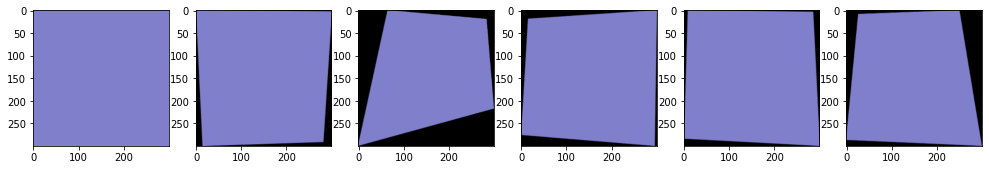

In [6]:
dummy_array = np.dstack([0.5 * np.ones((300, 300, 2)), 0.8 * np.ones((300, 300, 1))])
fig, ax = plt.subplots(1, 6, figsize=(17, 10))
ax[0].imshow(dummy_array)
for i in range(1, 6):
    ax[i].imshow(transform(image=dummy_array))

__Aggregation Operator__

We substitute the use of a point spread function in remote sensing by a discrete convolutive operator. 

Its associated convolutive kernel must hence match the downscaling ratio induced by the new spatial resolution. Here, we downscale the image by a `4 * 4` ratio of (`2048 * 2048` $\rightarrow$ `512 * 512`), hence this is going to be the size of our convolutional kernel.

As of now, we only propose heat kernel implementation.

In [7]:
# Compute kernel
heat_kernel = kernels.heat_kernel(size=(4, 4),
                                  sigma=1.)
print("Kernel shape : ", heat_kernel.shape)

# Aggregation operator
aggregate_fn = conv_aggregation(heat_kernel)

Kernel shape :  (4, 4)


> _Dummy example of how aggregation is performed_

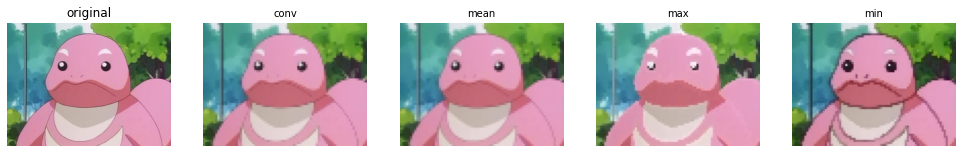

In [8]:
from skimage.measure import block_reduce

def downsample(img, size, aggregate_fn):
    # Compute aggregation blocks dimensions
    width, height, _ =    img.shape
    block_width = width // size[0]
    block_height = height // size[1]
    block_size = (block_width, block_height, 1)
    down_img = np.empty(size)
    # Split image into blocks
    downsampled_img = block_reduce(image=img, block_size=block_size, func=aggregate_fn)
    return downsampled_img


aggregate_fns = [conv_aggregation(heat_kernel), np.mean, np.max, np.min]
titles = ['conv', 'mean', 'max', 'min']
dummy_pic = np.asarray(Image.open('excelangue.jpg')) / 255.

fig, ax = plt.subplots(1, len(aggregate_fns) + 1, figsize=(17, 15))
ax[0].imshow(dummy_pic)
ax[0].axis('off')
ax[0].set_title('original')
for i, (agg, title) in enumerate(zip(aggregate_fns, titles)):
    downsampled_pic = downsample(img=dummy_pic, size=(60, 80), aggregate_fn=agg)
    ax[i + 1].imshow(downsampled_pic)
    ax[i + 1].axis('off')
    ax[i + 1].set_title(title, fontsize=10)

## Build and Execute Degrader instance

`Degrader` allows to run the following operations on the fly on a complete product dataset to generate a degraded version of it

In [9]:
# Instantiate degrader
degrader_kwargs = {'size': target_size,
                   'temporal_res': temporal_res,
                   'transform': transform,
                   'aggregate_fn': aggregate_fn}

degrader = Degrader(**degrader_kwargs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


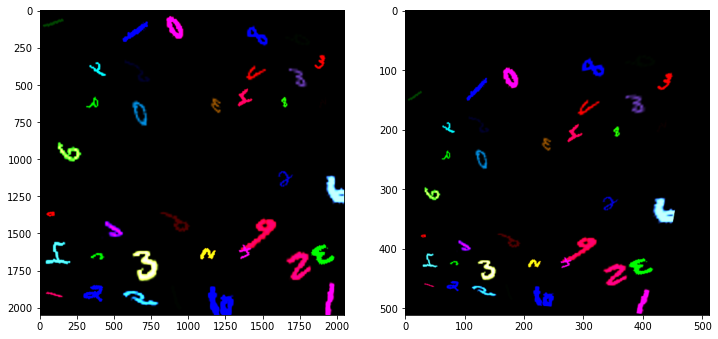

In [10]:
# Try on a sample
sample = latent[0]
degraded_sample = degrader(sample)

fig, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(sample)
ax[1].imshow(degraded_sample)
plt.show()

In [11]:
# Derive coarser product from latent dataset
# Progress bar should appear from command line
degrader.derive(product_set=latent,
                output_dir='sandbox/derived_product')

In [61]:
!tree sandbox/derived_product/

../../../coarser_product/
├── data
│   ├── step_0.npy
│   ├── step_1.npy
│   ├── step_10.npy
│   ├── step_11.npy
│   ├── step_12.npy
│   ├── step_13.npy
│   ├── step_14.npy
│   ├── step_15.npy
│   ├── step_16.npy
│   ├── step_17.npy
│   ├── step_18.npy
│   ├── step_19.npy
│   ├── step_2.npy
│   ├── step_20.npy
│   ├── step_21.npy
│   ├── step_22.npy
│   ├── step_23.npy
│   ├── step_24.npy
│   ├── step_25.npy
│   ├── step_26.npy
│   ├── step_27.npy
│   ├── step_28.npy
│   ├── step_29.npy
│   ├── step_3.npy
│   ├── step_30.npy
│   ├── step_31.npy
│   ├── step_4.npy
│   ├── step_5.npy
│   ├── step_6.npy
│   ├── step_7.npy
│   ├── step_8.npy

└── index.json

1 directory, 33 files
